Running models forwards and backwards

The value of simulations is highighted by Dr. McElreath throughout his textbook and by [van de Schoot and colleagues](nature.com/articles/s43586-020-00001-2.pdf). I didn't entirely appreciate its value until I implemented this myself. I started by reviewing some materials, then I went down a rabbit hole, where one question naturally branched into other questions. I'll talk about simulations in multiple posts and how model running [forwards](https://media.giphy.com/media/2bUpP71bbVnZ3x7lgQ/giphy.gif) and [backwards](https://media.giphy.com/media/g08eUPeabWkAOh6n4Q/giphy.gif) can help with understanding.

We'll start simple, with a weighted coin example. Then in later posts, we'll move into simple linear regression, then multiple linear regression and thinking from a causal perspective. As most of my recent posts have been inspired by my learning of Bayesian inference, much credit goes to Dr. McElreath's Statistical Rethinking, its associated [`pymc` repo](https://github.com/pymc-devs/resources/tree/master/Rethinking_2), and friends on the Discord server. Colleagues at UCSF who are experts in simulations and causal models have also been a great source.

Let's get started using our weighted coin example!

In [7]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
from scipy import stats
import statsmodels.api as sm
import seaborn as sns

sns.set_context("talk")

<IPython.core.display.Javascript object>

In [6]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz


def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


<IPython.core.display.Javascript object>

# Running models forwards and backwards

We can input parameters to generate data. Or we can start from data, come up with a model to infer a parameter. When most people do statistics, they're doing the latter. But running a model in both directions can help us understand things more deeply.

**insert graphic**

Let's pretend we have a weighted coin. (We'll use this in place of McElreath's globe tossing example.) In many problems, we're asked to deduce the true proportion that the coin comes up heads (or tails). This would be **parameter estimation** or what McElreath calls "running a model backwards". A parameter is typically *unobserved* in contrast to data, which we can observe. We can count the number of heads after a known number of tosses. But for simulation (running a model forwards), we input a *known parameter* (how weighted the coin is) and generate data.

In our simulation, let's say that the true proportion the coin comes up heads is 0.7. Since each coin toss is independent of the other, these are conditions for a binomial distribution. We'll illustrate simulations using [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) and inference using `pymc`. I'll also show how to do a simulation using `pymc` alone but I think using the `scipy.stats` module has more flexibility.

# Running forwards: simulation to get data

Let's imagine we do two coin flips. The possibilities after three tosses ($n$=2) is to observe 0 heads (H), 1 H, or 2 H. The number of observed heads is assigned $k$. Formally, the model equation with the known parameters will look like this.

$$ H \sim \text{Binomial}(n=2, p=0.7) $$

It can be read as "the number of heads we will observe is binomially distributed after two tosses of a coin, with true known proportion of heads of 0.7". We can get the probability mass function (PMF) for this distribution like this.

In [8]:
# k = 0, 1, or 2 heads
stats.binom.pmf(k=range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

<IPython.core.display.Javascript object>

This means that, after two coin flips, we expect to observe 0 heads  with 9% probability, 1 head with 42% probability, and 2 heads with 49% probability. These three possibilities sum to 100%. We can't get more hits on water ($k$) than the number of tosses ($n$). This is made clear if we try to input a value of $k$ that is $n$. (We'll do an explicit construction of a list of k values.)

In [9]:
stats.binom.pmf(k=[0, 1, 2, 3], n=2, p=0.7)

array([0.09, 0.42, 0.49, 0.  ])

<IPython.core.display.Javascript object>

We don't get an error, we simply get a probability of zero when $k > n$. Now let's simulate.

We can use `stats.binom.rvs` to input parameters and generate data. Let's do multiple trials, which is parameterized by `size`. To be clear, each trial means we're doing two tosses and recording the number of heads in that trial. We'll repeat this until we have 10 total trials.

In [10]:
# Use rvs to make dummy observations
stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 2, 1, 1, 1, 2, 2, 2, 2, 1])

<IPython.core.display.Javascript object>

If you keep executing this cell, you'll get a new set of values for observed W. We can also generate a high number of trials by simply making `size` large. We'll do 10,000 trials.

In [11]:
dummy_h = stats.binom.rvs(n=2, p=0.7, size=10 ** 5)
dummy_h

array([2, 2, 1, ..., 1, 1, 2])

<IPython.core.display.Javascript object>

And from here, we can see how well the proportion of samples for each water value generated by the simulation matches the proportions determined analytically (using `stats.binom.pmf`).

In [13]:
# Wrap the list in a series so I can use `value_counts`
pd.Series(dummy_h).value_counts() / 10 ** 5

2    0.48837
1    0.42089
0    0.09074
dtype: float64

<IPython.core.display.Javascript object>

The numbers are pretty close to our PMF we calculated above.

# Running backwards: inference to estimate the parameter

Now let's run the model backwards with `pymc` starting with the data that we generated from running the model forward. This might seem like a silly exercise since the purpose of inference is to estimate an unknown parameter. But the point of this exercise is to see how the two directions of model running are connected.

Here is our model equation.

$$ H \sim \text{Binomial}(n=2, p) $$
$$ p \sim \text{Beta}(\alpha=2, \beta=2) $$

We can read this as "the number of heads we will observe is binomially distributed after two tosses and some unknown parameter p." We have to give $p$ some plausible prior distribution. Since $p$ should be between 0 and 1, a beta distribution is a good choice. I wrote about the beta distribution in a prior post [here](https://benslack19.github.io/data%20science/statistics/prior-and-beta/).

I choice beta to be parameterized as (2,2) since it is fairly conservative, with most of the mass suggesting it is a fair coin. You'll see the shape of this below, when we put it with the posterior. We can get the posterior in the following code. **There is a closed form solution where we can get the posterior analytically. The following is a way to get it with MCMC. While using MCMC is overkill for this problem, it is applicable with more complicated models.**

In [15]:
# Generate observed data
dummy_h = stats.binom.rvs(n=2, p=0.7, size=10)

# Infer the parameter
with pm.Model() as m1:

    # prior
    p = pm.Beta("p", alpha=2, beta=2)

    # likelihood with unknown parameter p, observed dummy_h
    H = pm.Binomial("H", n=2, p=p, observed=dummy_h)

    # posterior
    trace_m1 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


<IPython.core.display.Javascript object>

Let's plot the prior and posterior for $p$ together.

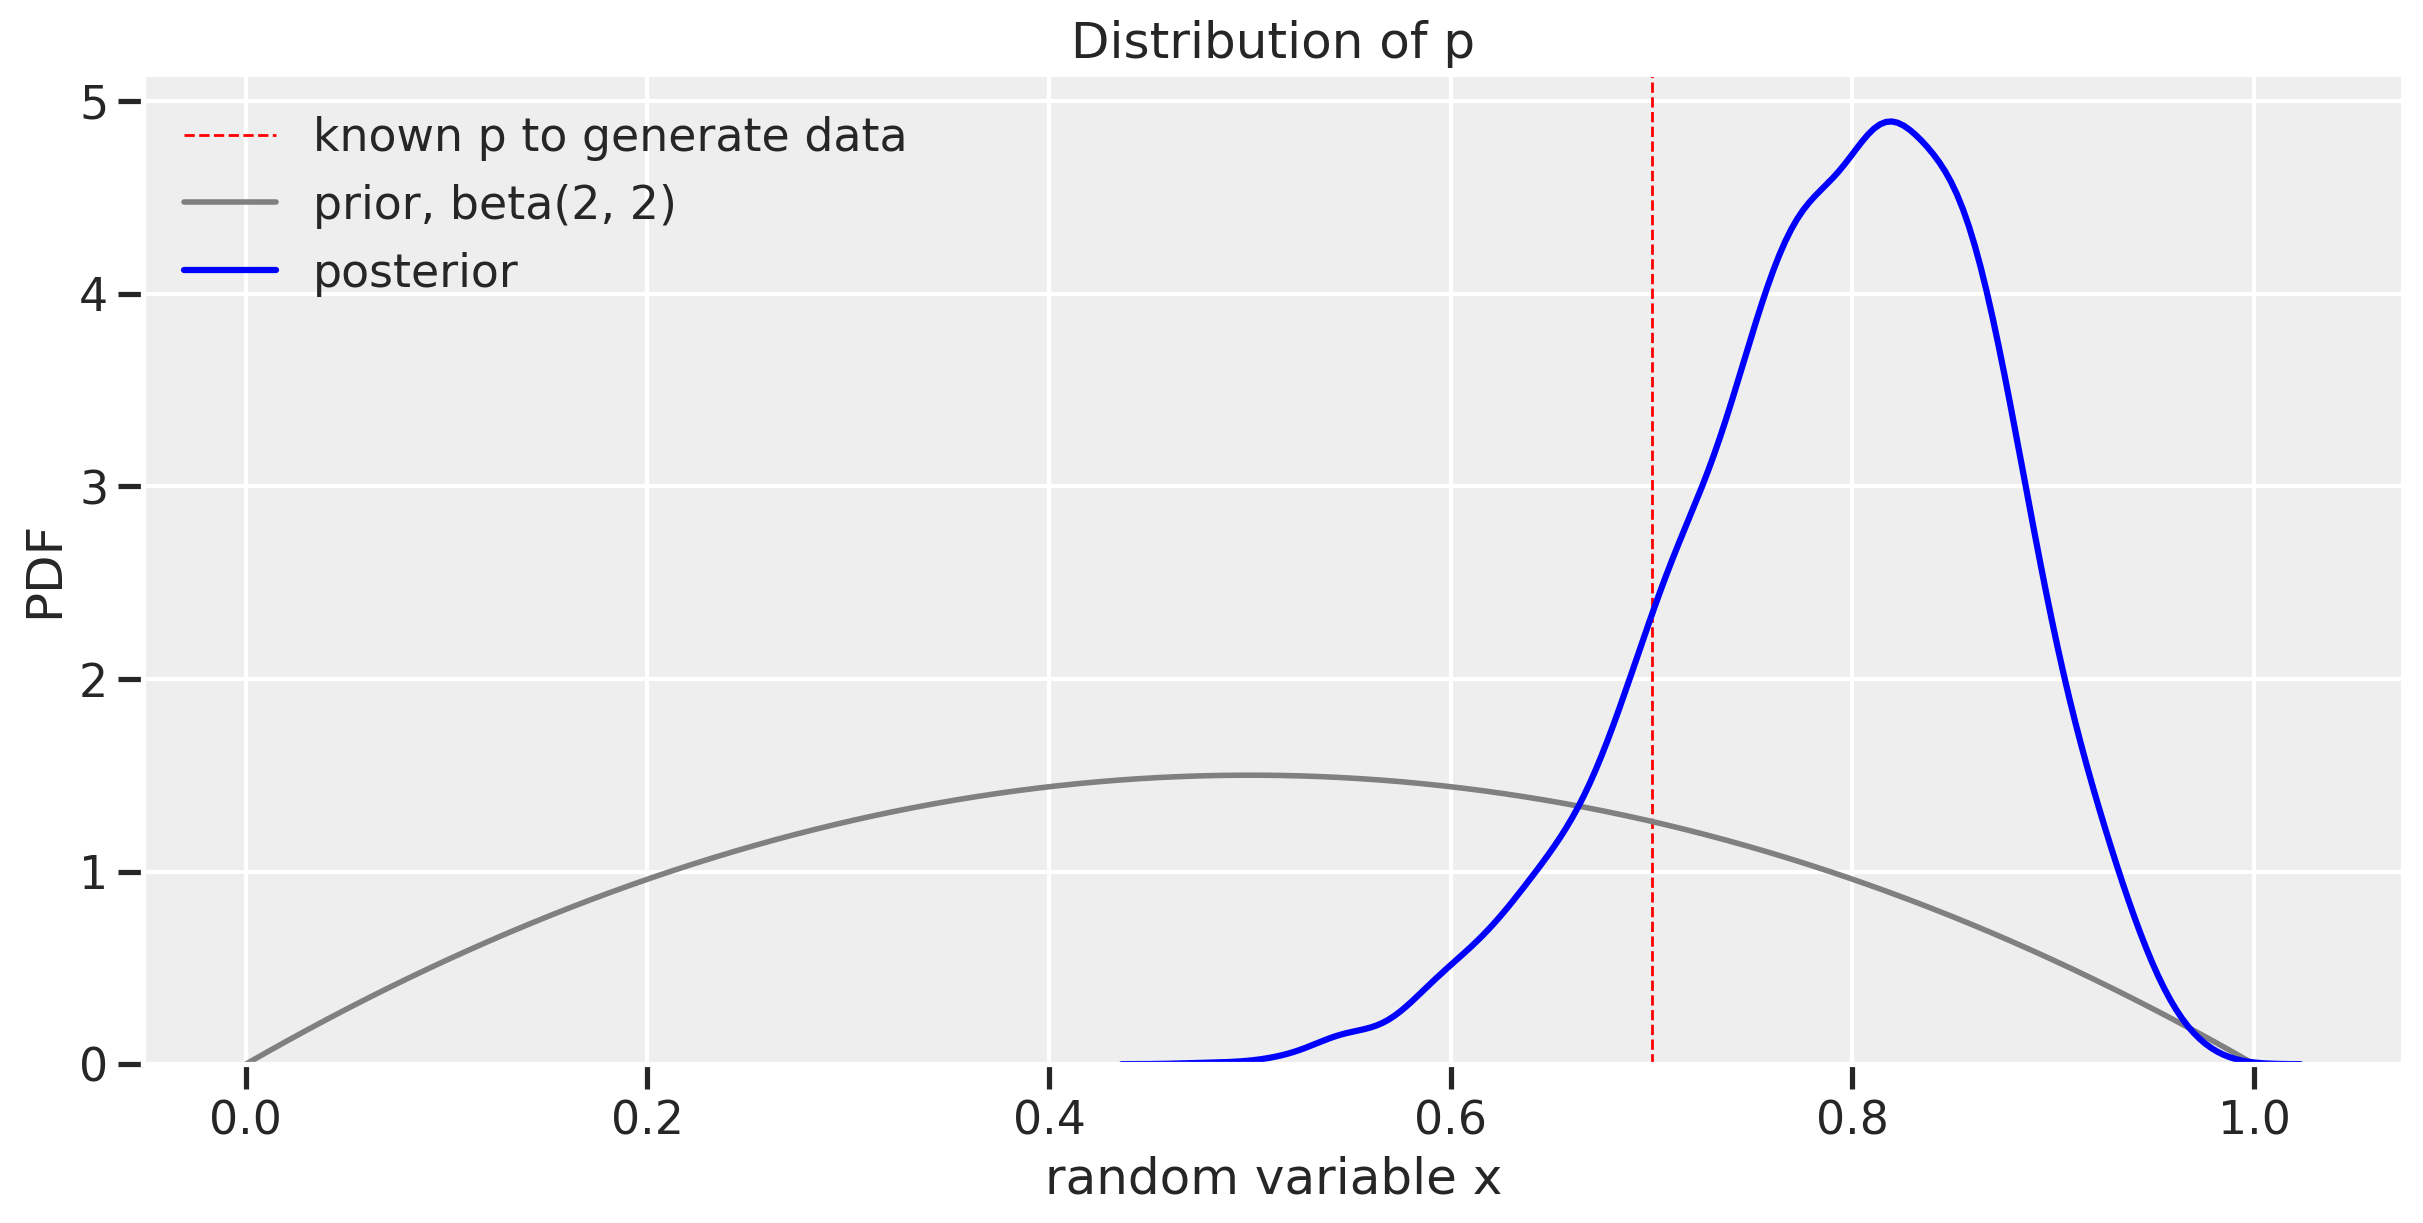

<IPython.core.display.Javascript object>

In [85]:
a = 2
b = 2

f, ax1 = plt.subplots(figsize=(12, 6))

# known parameter to generate data
ax1.axvline(
    0.7, lw=1, color="red", linestyle="dashed", label="known p to generate data"
)

# prior
x = np.linspace(stats.beta.ppf(0.00, a, b), stats.beta.ppf(1.00, a, b), 100)
prior_label = "prior, beta(" + str(a) + ", " + str(b) + ")"
ax1.plot(x, stats.beta.pdf(x, a, b), lw=2, color="gray", label=prior_label)

# Make the posterior values accessible and plot
df_trace_m1 = trace_m1.to_dataframe()
sns.kdeplot(df_trace_m1[("posterior", "p")], ax=ax1, color="blue", label="posterior")

ax1.set_title("Distribution of p")
ax1.set_xlabel("random variable x")
ax1.set_ylabel("PDF")
ax1.legend()

You can see how our distribution of $p$ narrows and gets closer to the known true value of 0.7, but hasn't centered over the true value yet. This will happen with more trials. But more of the probability mass is around 0.7 than the prior was. We can look more specifically at the 89% compatibility interval like this.

In [137]:
az.summary(trace_m1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.79,0.08,0.67,0.922,0.002,0.001,1697.0,1659.0,1692.0,2501.0,1.0


<IPython.core.display.Javascript object>

# Simulation with parameter distributions

The package `pymc` has its own prior (and posterior) simulations. We normally use this construction to specify a model with a prior and likelihood, but we can simply put in known parameters.

In [22]:
# For simulation
with pm.Model() as m2:

    # likelihood with known parameters
    H = pm.Binomial("H", n=2, p=0.7)
    
    # simulate
    prior_checks_m2 = pm.sample_prior_predictive(samples=10)

<IPython.core.display.Javascript object>

In [23]:
# The result is a dictionary
prior_checks_m2

{'H': array([1, 0, 2, 1, 2, 1, 1, 2, 1, 0])}

<IPython.core.display.Javascript object>

Often, it does not make sense to assume the parameter is a single, known quantity (like $p$=0.7) in simulations. Rather we can look at outcomes when a parameter is specified under a prior (or posterior) *distribution*. This can help us illustrate **the range of outcomes** our model is expecting.

In [131]:
# Generate observed data
dummy_h = stats.binom.rvs(n=2, p=0.7, size=10)

with pm.Model() as m3:

    # prior
    p = pm.Beta("p", alpha=2, beta=2)

    # likelihood, input the generated data as observed
    H = pm.Binomial("H", n=2, p=p, observed=dummy_h)

    # prior simulation
    prior_checks_m3 = pm.sample_prior_predictive(var_names=["p", "H"], samples=50)

    # posterior
    trace_m3 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=False
    )

    # posterior simulation
    posterior_checks_m3 = pm.sample_posterior_predictive(
        trace=trace_m3, var_names=["p", "H"], samples=50
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<IPython.core.display.Javascript object>

Let's look at both the prior and posterior simulations. The result of `pm.sample_prior_predictive` might be hard to discern at first, so let's walk through it. First, the result is a dictionary.

In [138]:
prior_checks_m3.keys()

dict_keys(['H', 'p'])

<IPython.core.display.Javascript object>

Essentially, we take a sampled $p$, pretend that is the true weight of a hypothetical coin, toss it twice, count the number of heads, and repeat 10 times. We have 50 $p$s (since we had `samples=50`) hence the resulting 50x10 array of $H$. Let's put this in a dataframe and plot.

In [140]:
df_prior = pd.DataFrame(prior_checks_m3["H"])
df_prior["p"] = prior_checks_m3["p"]

df_posterior = pd.DataFrame(posterior_checks_m3["H"])
df_posterior["p"] = posterior_checks_m3["p"]

<IPython.core.display.Javascript object>

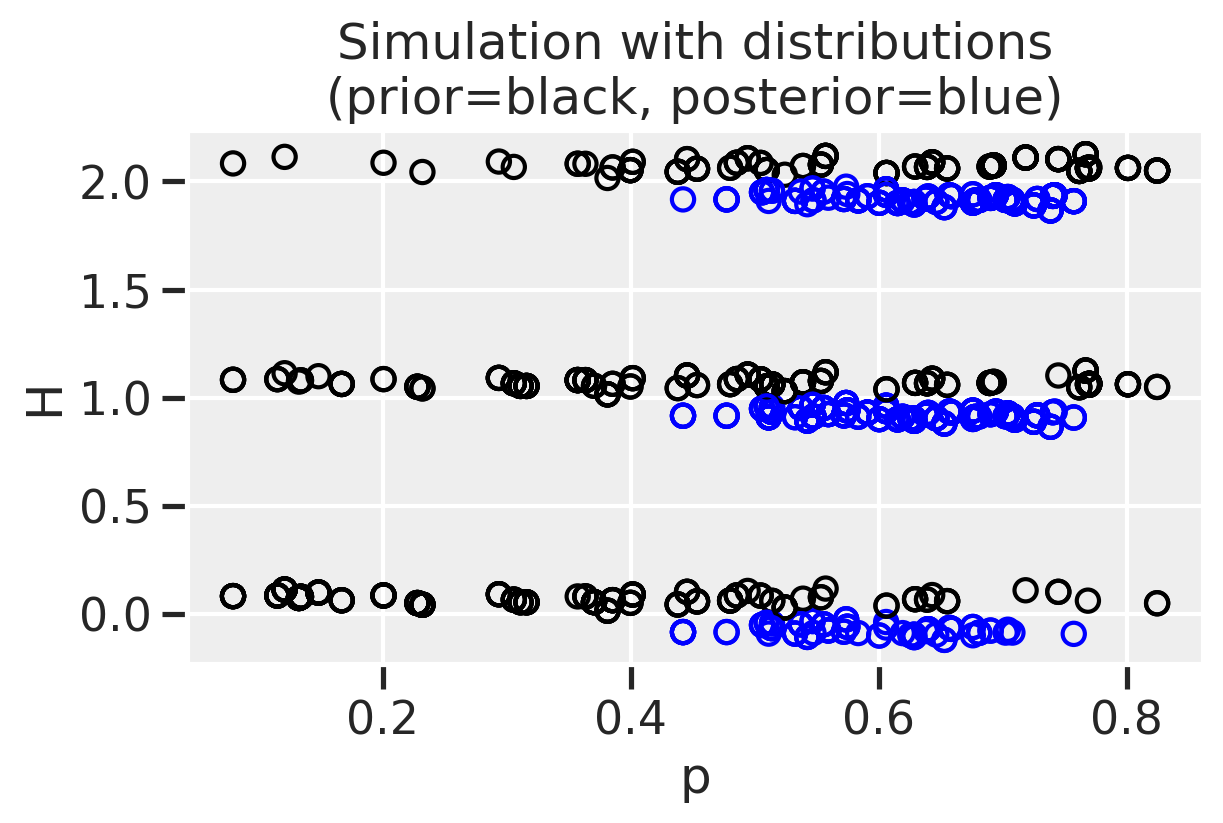

<IPython.core.display.Javascript object>

In [155]:
f, ax1 = plt.subplots(figsize=(6, 4))
y_jitter = np.random.normal(0, 0.025, size=len(prior_checks_m3["p"]))
for i in range(10):
    ax1.scatter(
        df_prior["p"],
        df_prior[i] + 0.075 + y_jitter,
        s=2 ** 6,
        facecolors="none",
        edgecolors="k",
    )

    ax1.scatter(
        df_posterior["p"],
        df_posterior[i] - 0.075 + y_jitter,
        s=2 ** 6,
        facecolors="none",
        edgecolors="blue",
    )

ax1.set(
    xlabel="p",
    ylabel="H",
    title="Simulation with distributions\n(prior=black, posterior=blue)",
)


In [163]:
(df_prior.iloc[0, 0:10])

0    2.0
1    2.0
2    1.0
3    2.0
4    1.0
5    2.0
6    1.0
7    1.0
8    2.0
9    2.0
Name: 0, dtype: float64

<IPython.core.display.Javascript object>

2.0    6
1.0    4
Name: 0, dtype: int64

<IPython.core.display.Javascript object>

<BarContainer object of 2 artists>

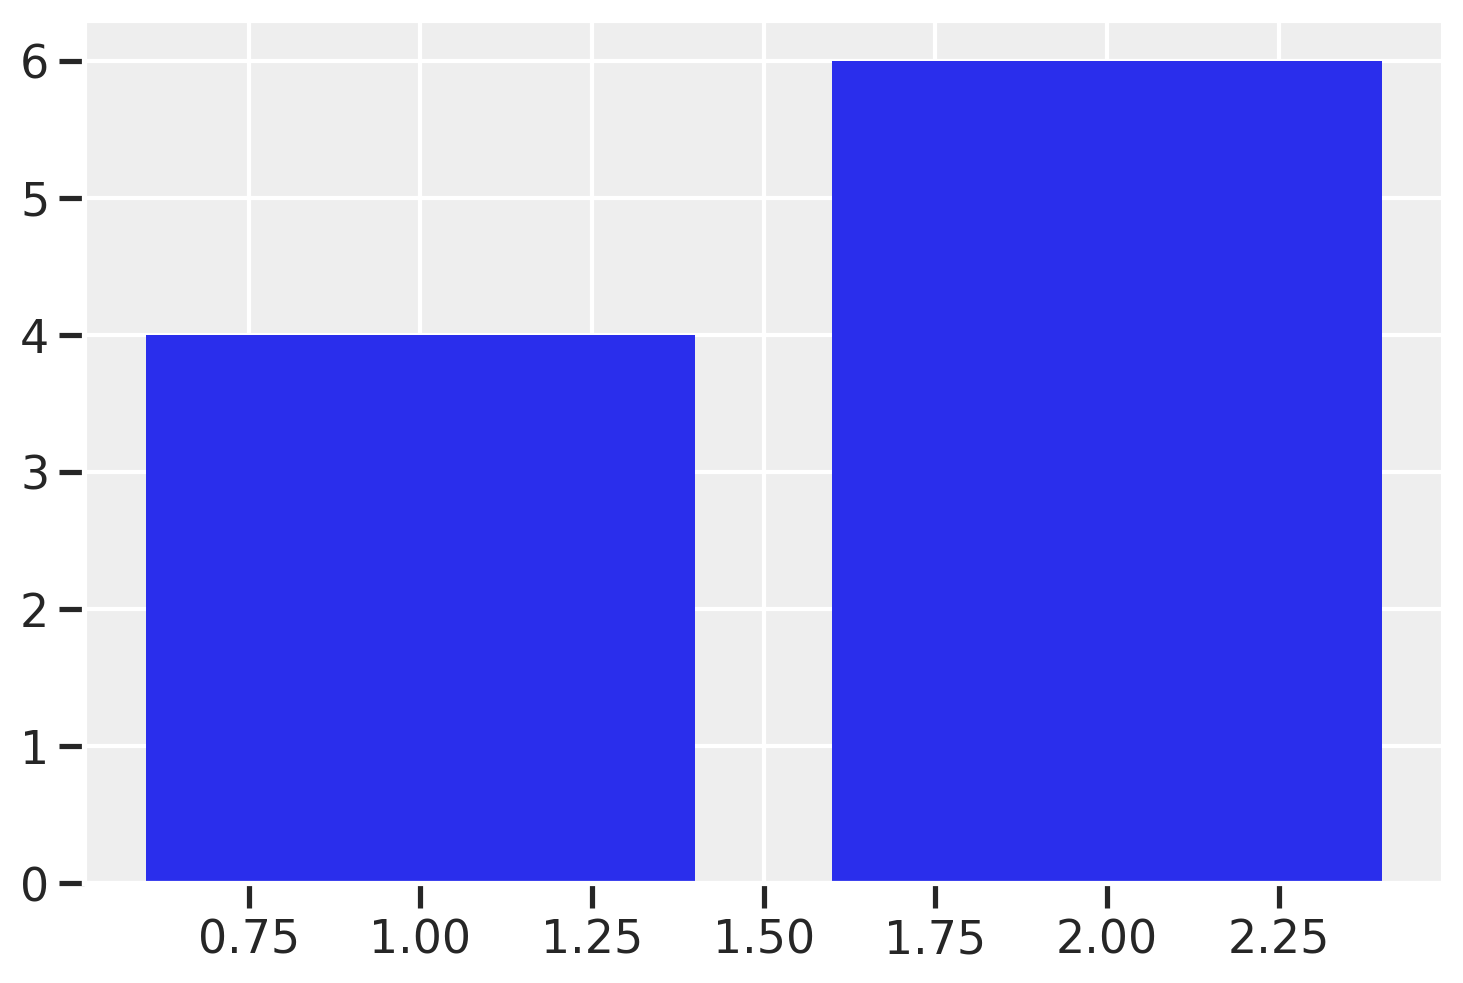

<IPython.core.display.Javascript object>

In [172]:
plt.bar(
    df_prior.iloc[0, 0:10].value_counts().index, df_prior.iloc[0, 0:10].value_counts()
)

In [176]:
df_prior["p"][0]

0.7694325138119464

<IPython.core.display.Javascript object>

In [182]:
df_prior.shape

(50, 11)

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


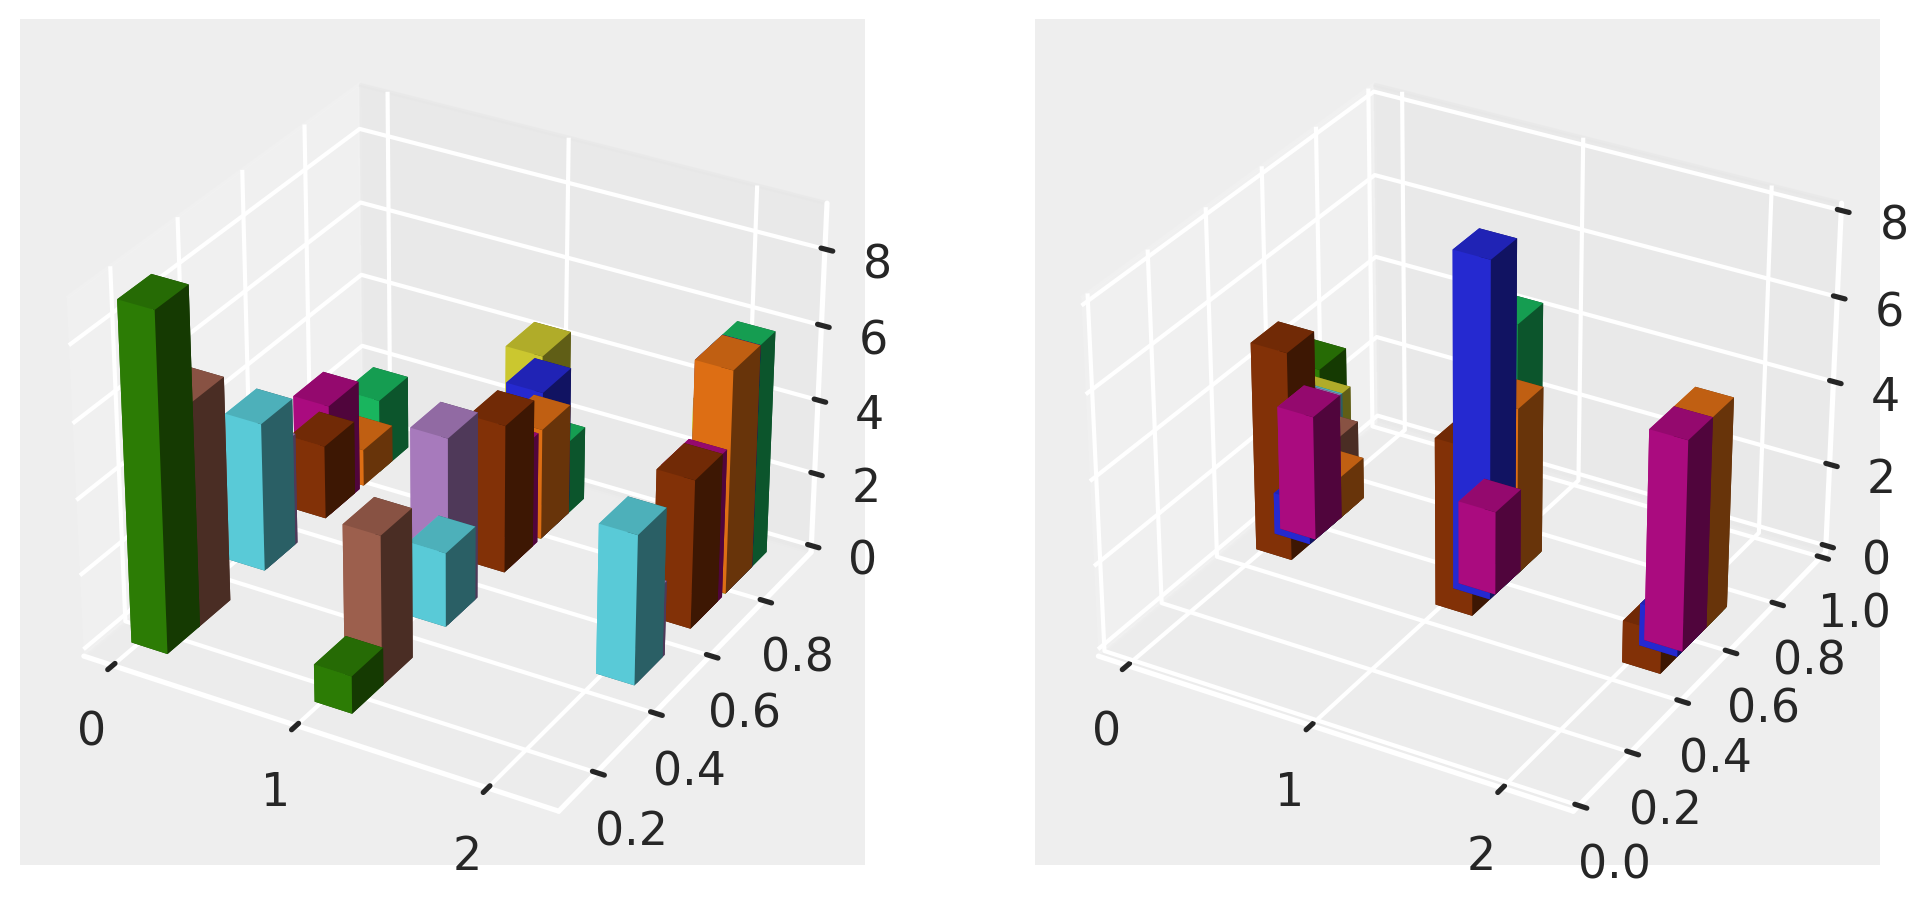

<IPython.core.display.Javascript object>

In [221]:
# setup the figure and axes
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

width = 0.2
depth = 0.1

for i in range(10):
    x = df_prior.iloc[i, 0:10].value_counts().index
    y = df_prior["p"][i]
    top = df_prior.iloc[i, 0:10].value_counts()
    bottom = np.zeros_like(top)
    ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
    ax1.set_xticks(range(3))
    ax1.set_xticklabels(range(3))

for i in range(10):
    x = df_posterior.iloc[i, 0:10].value_counts().index
    y = df_posterior["p"][i]
    top = df_posterior.iloc[i, 0:10].value_counts()
    bottom = np.zeros_like(top)
    ax2.bar3d(x, y, bottom, width, depth, top, shade=True)
    ax2.set_ylim([0, 1])
    ax2.set_xticks(range(3))
    ax2.set_xticklabels(range(3))

<AxesSubplot:xlabel='0', ylabel='Density'>

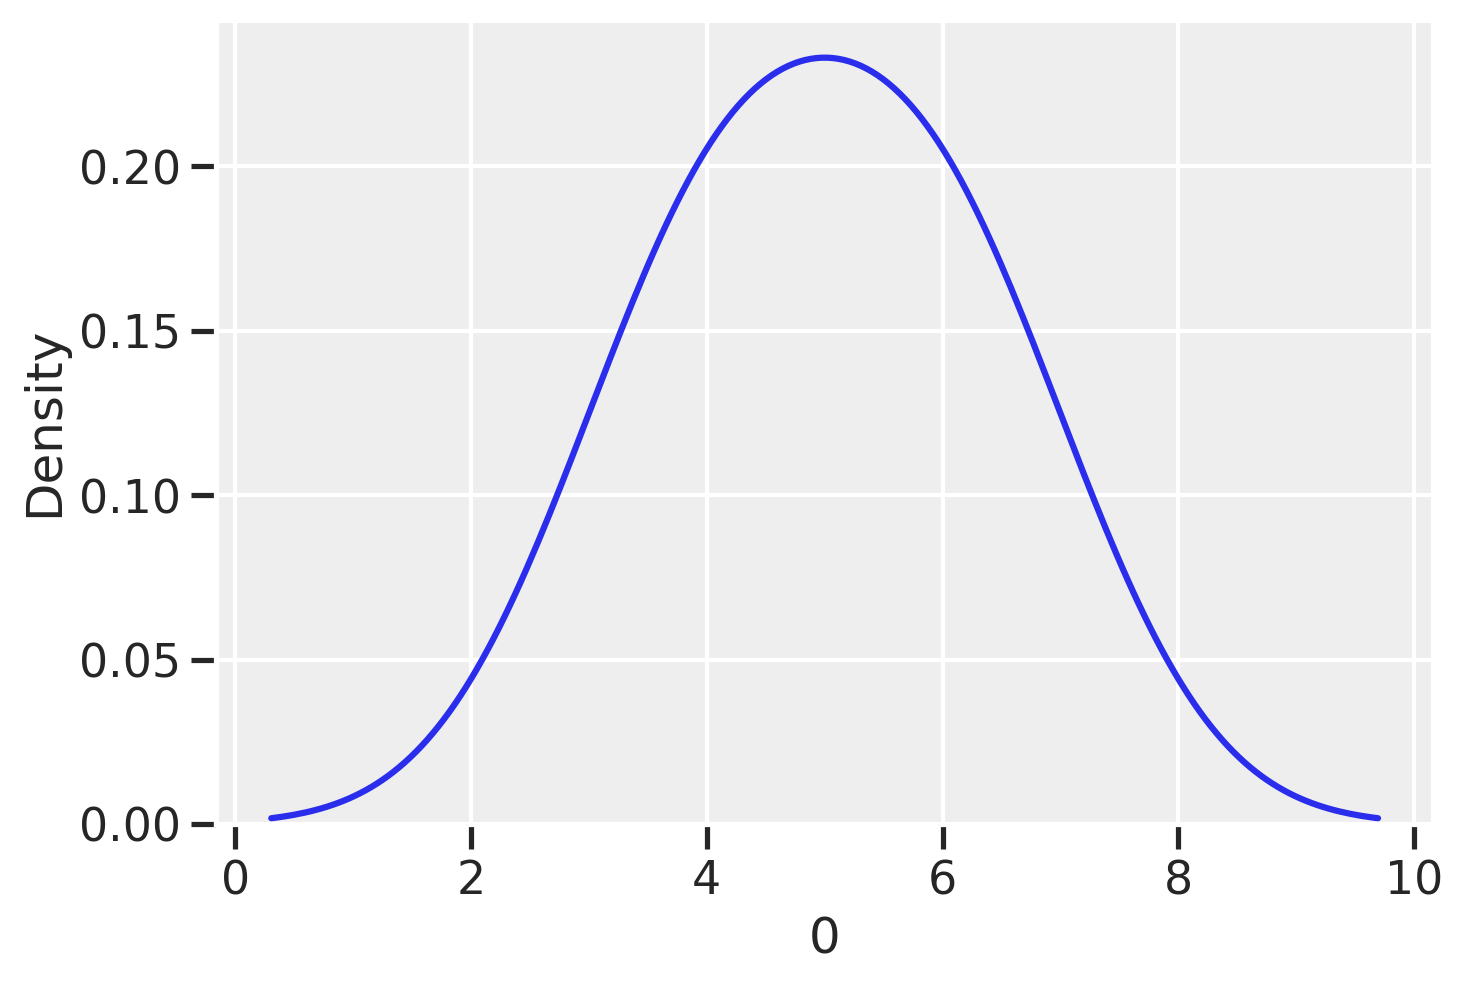

<IPython.core.display.Javascript object>

In [162]:
sns.kdeplot((df_prior.iloc[0, 0:10]).value_counts())

<AxesSubplot:ylabel='Density'>

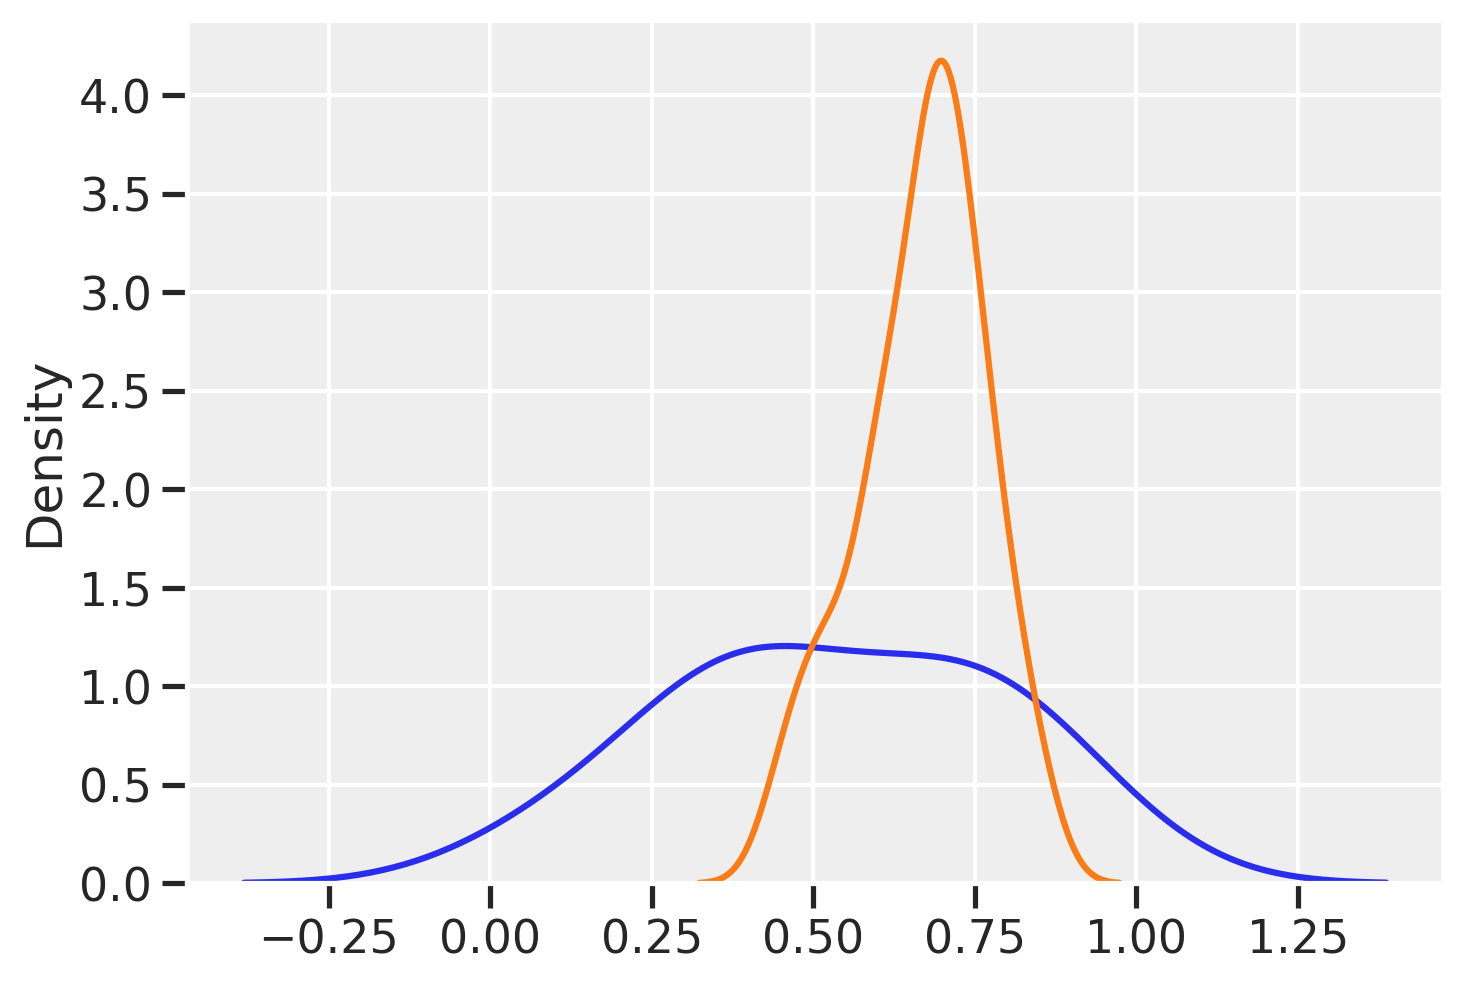

<IPython.core.display.Javascript object>

In [99]:
f, ax1 = plt.subplots()
sns.kdeplot(prior_checks_m3["p"], ax=ax1)
sns.kdeplot(posterior_checks_m3["p"], ax=ax1)

In [75]:
df_prior_m3 = pd.DataFrame(prior_checks_m3)
df_posterior_m3 = pd.DataFrame(posterior_checks_m3)

<IPython.core.display.Javascript object>

In [130]:
df_prior

,0,1,2,3,4,5,6,7,8,9,p
0,2,2,1,2,2,2,2,1,2,2,0.833574
1,0,1,0,0,1,0,1,1,0,0,0.267953
2,1,1,1,0,2,0,1,1,1,1,0.393836
3,1,2,2,2,2,2,2,2,2,2,0.928088
4,2,1,1,2,0,0,1,0,2,2,0.617632
5,1,0,1,1,0,0,1,0,2,0,0.397074
6,2,1,1,0,0,0,1,2,1,2,0.628315
7,2,2,2,2,1,0,2,2,1,2,0.657061
8,1,1,1,0,1,0,1,1,2,1,0.538507
9,2,1,1,2,1,2,1,1,2,1,0.517020


<IPython.core.display.Javascript object>

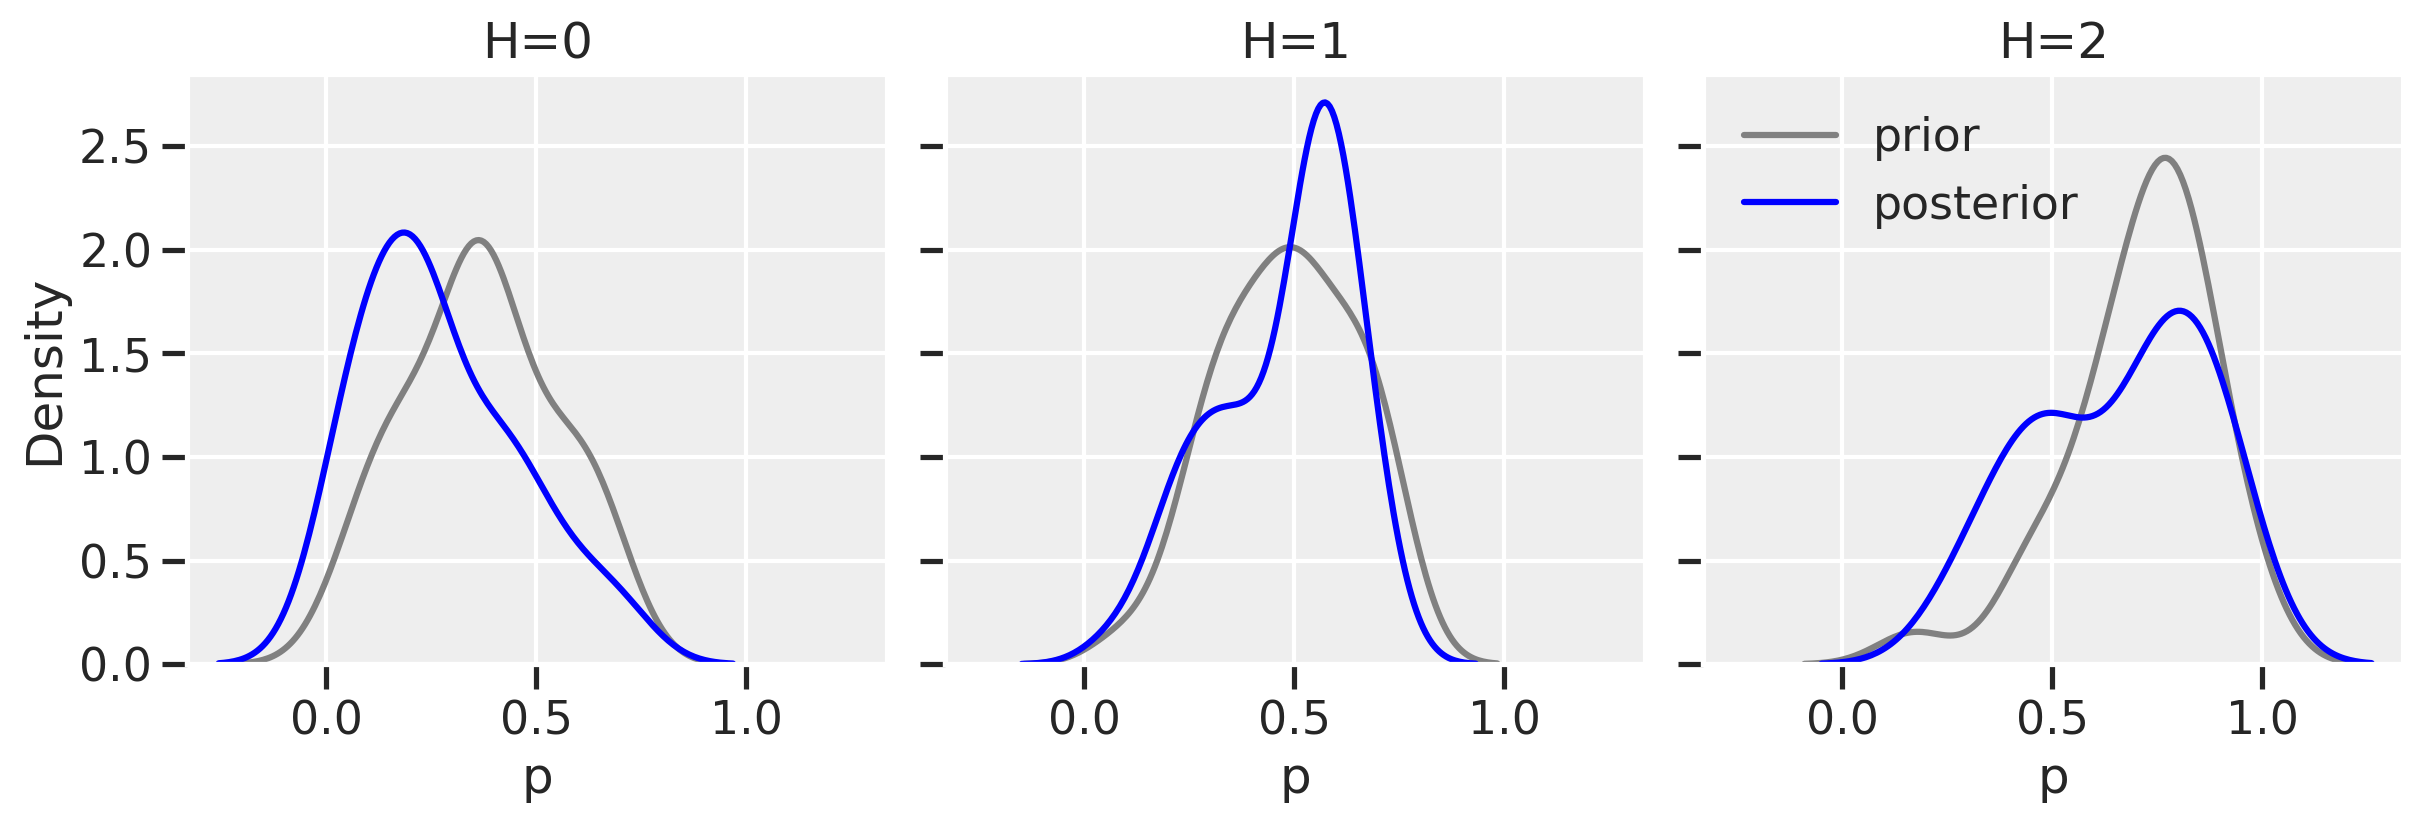

<IPython.core.display.Javascript object>

In [86]:
f, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
for i in range(3):
    sns.kdeplot(
        df_prior_m3.loc[df_prior_m3["H"] == i, "p"],
        color="gray",
        ax=axes[i],
        label="prior",
    )
    sns.kdeplot(
        df_posterior_m3.loc[df_posterior_m3["H"] == i, "p"],
        color="blue",
        ax=axes[i],
        label="posterior",
    )
    axes[i].set_title(f"H={i}")
axes[2].legend()

<AxesSubplot:xlabel='p', ylabel='Density'>

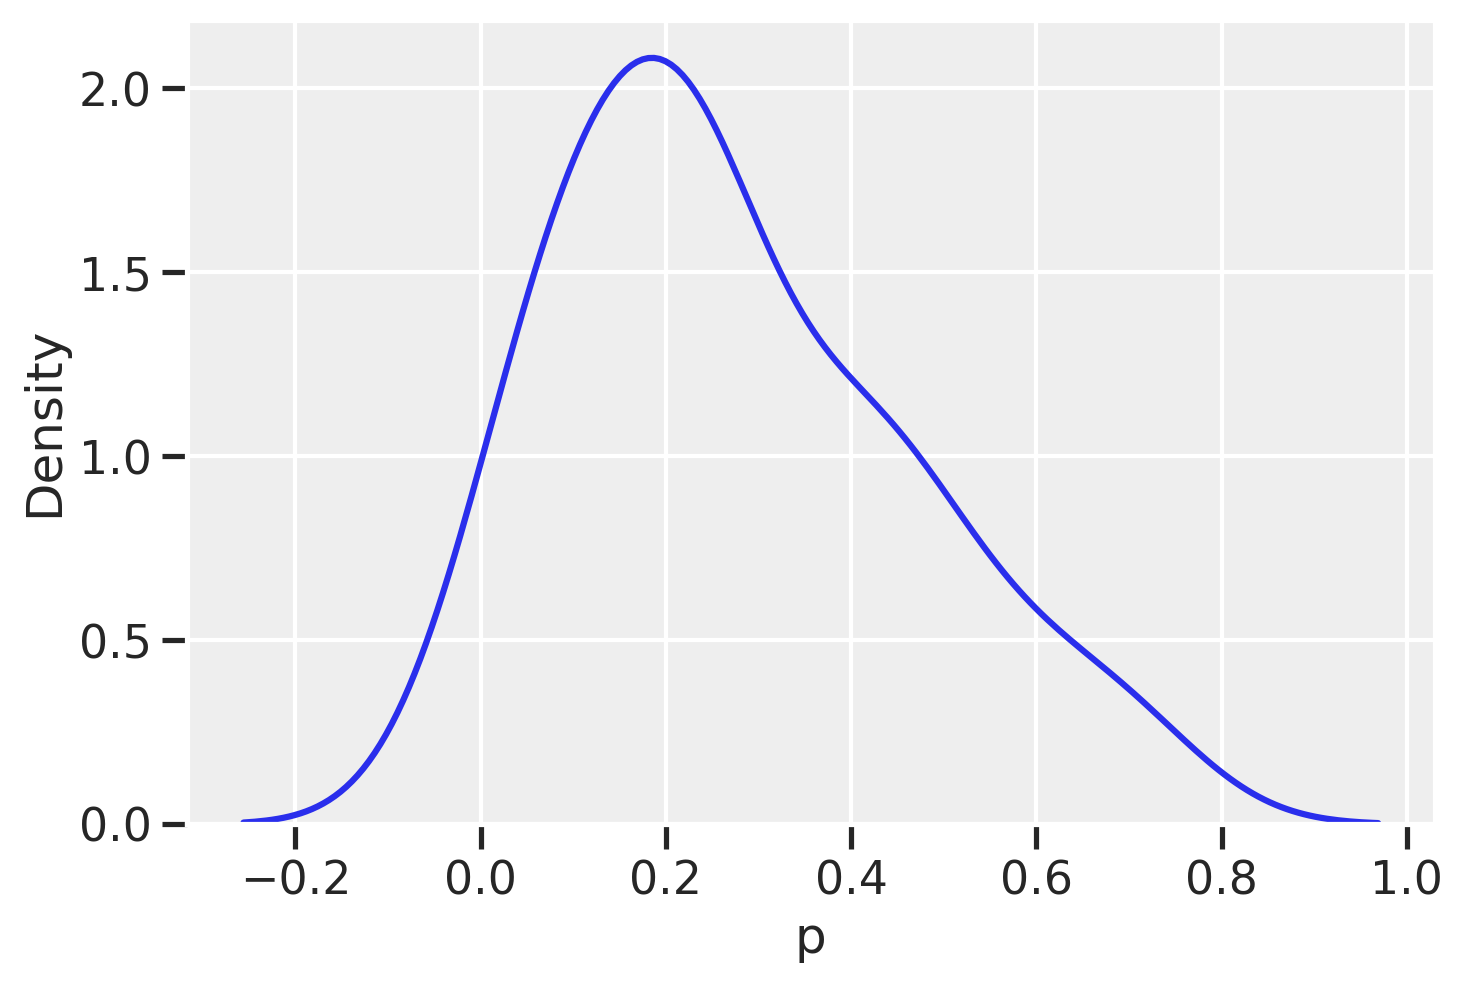

<IPython.core.display.Javascript object>

In [72]:
sns.kdeplot(df_posterior_m3.loc[df_posterior_m3["H"] == 0, "p"])

In [57]:
trace_m3.to_dataframe()

,chain,draw,"(posterior, H)","(posterior, p)","(sample_stats, step_size_bar)","(sample_stats, perf_counter_start)","(sample_stats, diverging)","(sample_stats, process_time_diff)","(sample_stats, perf_counter_diff)","(sample_stats, tree_size)","(sample_stats, accept)","(sample_stats, mean_tree_accept)","(sample_stats, step_size)","(sample_stats, energy_error)","(sample_stats, lp)","(sample_stats, depth)","(sample_stats, scaling)","(sample_stats, max_energy_error)","(sample_stats, energy)","(sample_stats, accepted)"
0,0,0,2,0.705312,1.078733,1779.159240,False,0.000371,0.000371,1.0,0.000000,0.483877,0.771520,0.000000,0.0,1,1.61051,0.725924,2.453482,False
1,0,1,2,0.775059,1.078733,1779.160004,False,0.000275,0.000274,1.0,0.000000,0.916478,0.771520,0.087217,0.0,1,1.61051,0.087217,2.226264,False
2,0,2,2,0.775059,1.078733,1779.160606,False,0.000549,0.000549,3.0,0.000000,0.143727,0.771520,0.000000,0.0,2,1.61051,1.939837,3.436089,False
3,0,3,2,0.883213,1.078733,1779.161439,False,0.000342,0.000343,1.0,1.000000,0.730973,0.771520,0.313379,0.0,1,1.61051,0.313379,3.045496,True
4,0,4,2,0.842774,1.078733,1779.162161,False,0.000363,0.000362,1.0,0.000000,1.000000,0.771520,-0.133326,0.0,1,1.61051,-0.133326,3.063633,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3,995,1,0.839879,1.288784,1781.136185,False,0.000335,0.000334,3.0,0.095324,1.000000,1.508485,-0.948199,0.0,2,1.61051,1.878742,8.373391,False
3996,3,996,1,0.770603,1.288784,1781.136724,False,0.000251,0.000251,1.0,0.000000,1.000000,1.508485,-0.251504,0.0,1,1.61051,-0.251504,3.580078,False
3997,3,997,1,0.113104,1.288784,1781.137172,False,0.000353,0.000353,3.0,0.063764,0.803667,1.508485,0.805882,0.0,2,1.61051,0.805882,5.050249,False
3998,3,998,0,0.257556,1.288784,1781.137730,False,0.000189,0.000189,1.0,1.441329,1.000000,1.508485,-0.577662,0.0,1,1.61051,-0.577662,3.934966,True


<IPython.core.display.Javascript object>

In [175]:
# For inference

p = []

with pm.Model() as m1:
    
    # prior
    p1 = pm.Beta("p", alpha=2, beta=2)

    # likelihood, input the generated data as observed
    W = pm.Binomial("W", n=2, p=p, observed=prior_checks["W"])

    # sample
    trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [176]:
az.summary(trace_m1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.685,0.057,0.595,0.774,0.001,0.001,1651.0,1651.0,1673.0,2835.0,1.0


<IPython.core.display.Javascript object>

In [18]:
prior_checks["W"]

array([2, 1, 2, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2,
       0, 1, 2, 1, 0, 1, 2, 2])

<IPython.core.display.Javascript object>

In [10]:
# For sample size test

est_p = dict()

for sample_size in [2, 5, 10, 25, 50]:

    with pm.Model() as m1:

        # prior
        p = pm.Beta("p", alpha=2, beta=2)
        
        w = stats.binom.rvs(n=2, p=0.7, size=10**5)
        

        # likelihood, input the generated data as observed
        W = pm.Binomial("W", n=n, p=p, observed=prior_checks["W"])

        # sample
        trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

    est_p[n] = az.summary(trace_m1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.8792634270356184, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8878256109794483, but should be close to 0.8. Try to increase the number of tuning steps.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

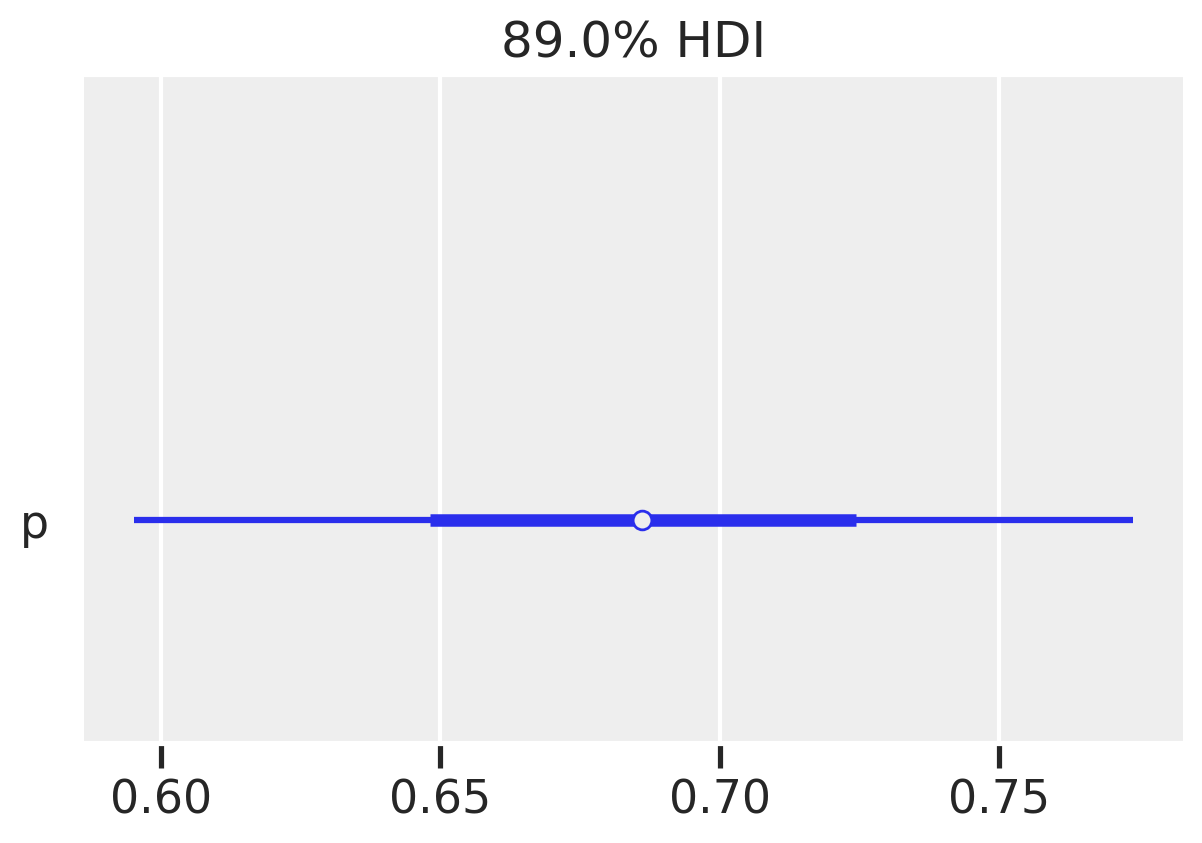

<IPython.core.display.Javascript object>

In [178]:
az.plot_forest(trace_m1, combined=True)

Give $n$ a distribution. Want something bounded by zero or positive. Gamma distribution will work.

In [204]:
stats.gamma.rvs(2, size=100).mean()

1.84225689439146

<IPython.core.display.Javascript object>

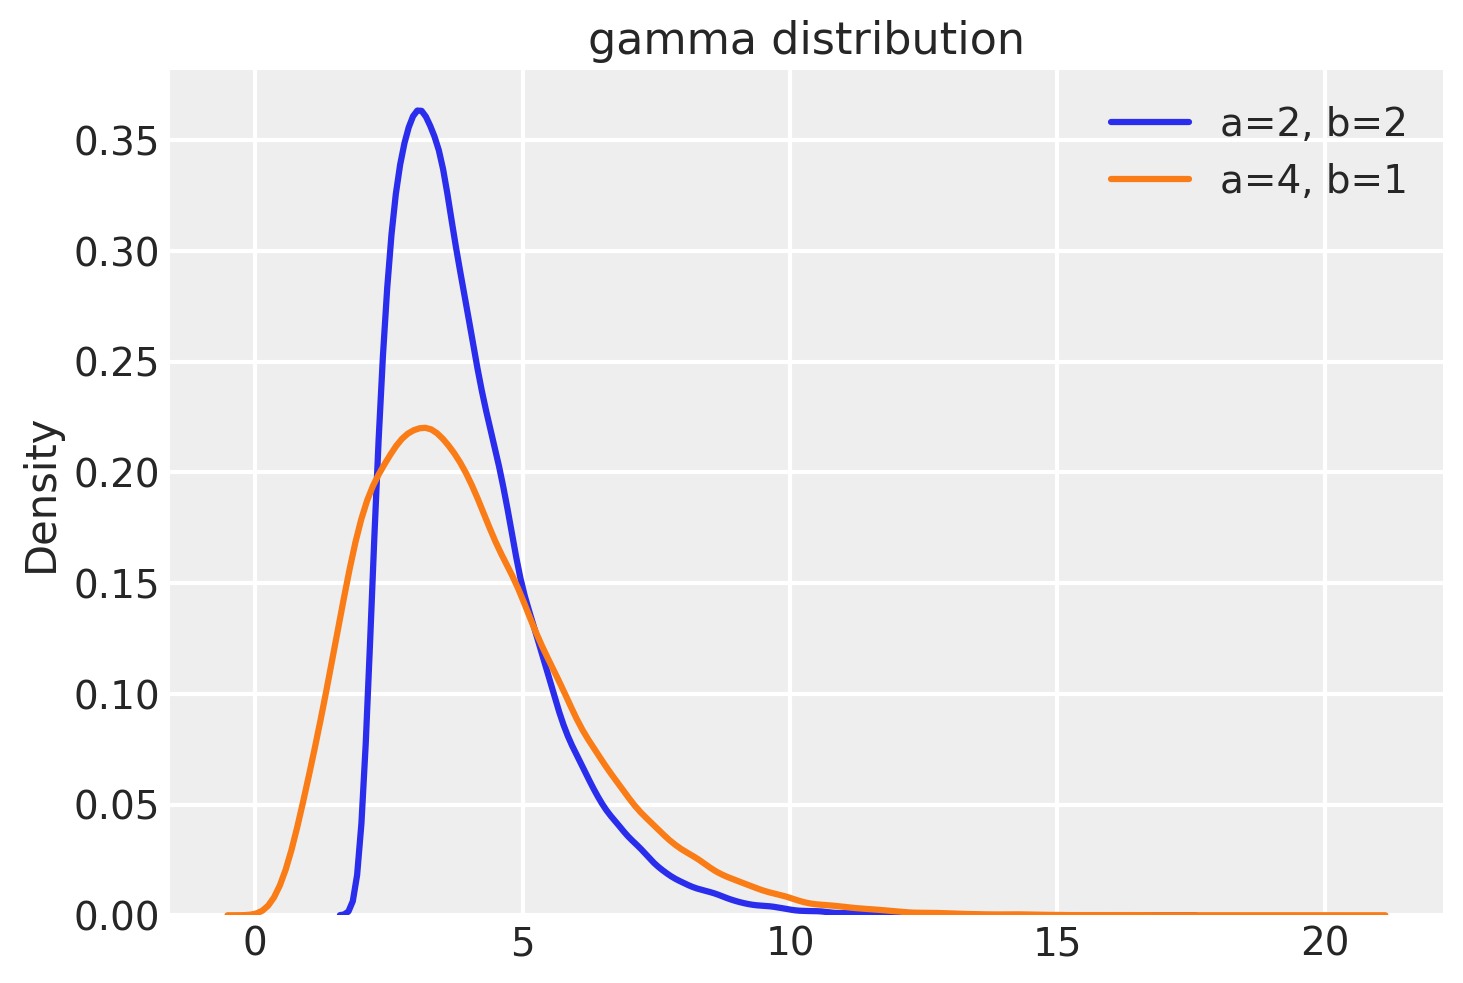

<IPython.core.display.Javascript object>

In [156]:
f, ax1 = plt.subplots()
sns.kdeplot(stats.gamma.rvs(2, 2, size=10**5), ax=ax1, label='a=2, b=2')
sns.kdeplot(stats.gamma.rvs(4, size=10**5), ax=ax1, label='a=4, b=1')    # default scale is 1 (1/b)
ax1.set_title('gamma distribution')
ax1.legend()

In [71]:
np.exp(-100)

3.720075976020836e-44

<IPython.core.display.Javascript object>

In [195]:
with pm.Model() as m2:

    # prior
    # n = pm.Gamma("n", alpha=2, beta=2)
    p = pm.Beta("p", alpha=2, beta=2)

    # likelihood
    W = pm.Binomial("W", n=2, p=p)

    # sample
    trace_m2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)
    prior_checks = pm.sample_prior_predictive(samples=10**5)

prior_checks['W'][0:10]
pd.Series(prior_checks['W']).value_counts() / 10**5

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [p]
INFO:pymc3:>NUTS: [p]
>Metropolis: [W]
INFO:pymc3:>Metropolis: [W]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


1    0.40024
0    0.30035
2    0.29941
dtype: float64

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [5]:
%watermark -n -u -v -iv -w

Last updated: Mon Jan 03 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pymc3      : 3.11.0
scipy      : 1.6.0
numpy      : 1.20.1
pandas     : 1.2.1
matplotlib : 3.3.4
json       : 2.0.9
seaborn    : 0.11.1
arviz      : 0.11.1
statsmodels: 0.12.2

Watermark: 2.1.0



<IPython.core.display.Javascript object>